In [137]:
# Initialization

import math
from datetime import datetime
import openpyxl as opxl
from openpyxl.utils.dataframe import dataframe_to_rows
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import model as ty
import proc as pr
import matplotlib.ticker as mtick
import sklearn.metrics

import scipy.constants as scc

import sys
sys.path.append('../RD-systems-and-test-benches')

import thermal.SK_standard as nm

import seaborn as sns

import utils.plot_functions as RD_pfun
import repo_config as rconfig

from IPython.core.display import HTML

import heat_transfer as bht

import fluids as fds
import ht 

import general as gen

import os

import scipy.integrate as integrate
import scipy.optimize as sco

import networkx as nx

import plotly.graph_objects as go

import plot_functions_here as pfun

import plotly.io as pio

from itertools import product
from itertools import chain

from tqdm.notebook import tqdm

import copy

from concurrent.futures import ProcessPoolExecutor

In [138]:
import repo_config as rconfig

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec
import matplotlib_inline

import scienceplots

matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
plt.style.use(['science'])

def to_percent(y, _):
    return f"{y * 100:.0f}\%"

# colors = ['olive', 'green', 'blue', 'orange', 'red', 'grey','yellow','bordeaux']
colors = ['olive', 'blue', 'orange']
colors_lighter = [rconfig.get_hex_code(color, 70) for color in colors]
colors = [rconfig.get_hex_code(color, 100) for color in colors]
linestyles = ['-', '--',  (5, (10, 3)), '-.', (0, (1, 1)), (0, (3, 5, 1, 5))]
markers = ['o', 's', 'd']

In [139]:
folder_path = r'G:\Drive partagés\Cercle Hard\R&D\Modèles numériques PVT\PVT-perf-1Dmodel'
geometry_path = os.path.join(folder_path, 'Panels\\Panel_V4.1I.xlsx')
hypotheses_path = folder_path + '\\' + 'Hypotheses\\Model_hypotheses_calibrated_V4.411.xlsx'

# panelSpecs = pr.import_geometry(geometry_path)
# hyp = pr.create_dict_from_excel(hypotheses_path,'Main')

# steadyStateConditions_df = pd.read_excel(condi_path,header=2) ## Les deux première lignes ne sont pas à prendre en compte
# stepConditions = steadyStateConditions_df.to_dict(orient='records')

In [140]:
recap = pd.read_excel(r'G:\Drive partagés\Cercle Hard\R&D\Thermal performance tests PVT\Recap_RD_TUV_SSI.xlsx')
recap = recap.drop(index=0)
recap.dropna(how='all', inplace=True)

groups = {key: group for key, group in recap.groupby('Design')}

In [141]:
triplets = [
            {'design_name' : 'V4.31',
             'test_type' : 'SK'},
            {'design_name' : 'V4.32',
                'test_type' : 'SK'},
                ]

Panel_name = {'V4.31' : 'V4.31_ExtrudedFins',
              'V4.32' : 'V4.32_ExtrudedRisersAndFins'}

for triplet in triplets:
             
    triplet['panelSpecs'] = pr.import_geometry(os.path.join(f'{folder_path}\\Panels', f"Panel_{Panel_name[triplet['design_name']]}.xlsx"))
        
    triplet['hyp'] = pr.create_dict_from_excel(hypotheses_path,'Main')
    triplet['steadyStateConditions_df'] = groups[triplet['design_name']].loc[groups[triplet['design_name']]['Type'] == triplet['test_type']].copy()
    pr.adjust_steadyStateConditions(triplet['steadyStateConditions_df'],triplet['hyp'],convert_celsius=True)

    triplet['steadyStateConditions_df'] = triplet['steadyStateConditions_df'].loc[(triplet['steadyStateConditions_df']['u'] != " ")]
    triplet['steadyStateConditions_df']['u'] = triplet['steadyStateConditions_df']['u'].astype(float)
    triplet['steadyStateConditions_df'] = triplet['steadyStateConditions_df'].loc[(triplet['steadyStateConditions_df']['u'] >= 0.1)]
    triplet['steadyStateConditions_df'] = triplet['steadyStateConditions_df'].loc[(triplet['steadyStateConditions_df']['Qdot'] > 25)]

    triplet['steadyStateConditions_df'].reset_index(drop=True,inplace=True)

In [142]:
k0 = 0

df_res,list_res = ty.simu_steadyStateConditions(triplets[k0]['panelSpecs'],triplets[k0]['hyp'],triplets[k0]['steadyStateConditions_df'])

triplets[k0]['df_res'] = df_res

In [143]:
triplets[k0]['steadyStateConditions_df']['Qdot/AG'] = triplets[k0]['steadyStateConditions_df']['Qdot'] / triplets[k0]['panelSpecs']['AG']
triplets[k0]['df_res']['Qdot/AG'] = triplets[k0]['df_res']['Qdot_tube_fluid'] / triplets[k0]['panelSpecs']['AG']

tab_mat,tab_res,X = nm.find_SK(triplets[k0]['steadyStateConditions_df'],dic_names_exp,columns_list=[1,1,0,1,1,0,1,1,0],options=[],IAM=False,LSM='nnls')
triplets[k0]['steadyStateConditions_df']['Qdot/AG_reg'] = tab_mat @ X[0]
tab_mat,tab_res,X1 = nm.find_SK(triplets[k0]['df_res'],dic_names_num,columns_list=[1,1,0,1,1,0,1,1,0],options=[],IAM=False,LSM='nnls')
triplets[k0]['df_res']['Qdot/AG_reg'] = tab_mat @ X1[0]
print('exp', X[0])
print('num', X1[0])

print('b1', X1[0][1] - 3* X1[0][3])
print('A1(1.3)', X1[0][1] - 1.7* X1[0][3])

exp [3.88360180e-01 1.71418528e+01 0.00000000e+00 1.29561916e+00
 0.00000000e+00 0.00000000e+00 1.30051211e-02 0.00000000e+00
 0.00000000e+00]
num [ 0.38821162 16.31429824  0.          1.10265446  0.          0.
  0.02398964  0.          0.        ]
b1 13.006334878434433
A1(1.3) 14.439785670470247


In [144]:
triplets[k0]['df_res']['error'] = (triplets[k0]['df_res']['Qdot_tube_fluid'] - triplets[k0]['steadyStateConditions_df']['Qdot'])

In [145]:
triplets[k0]['df_res']['error'].abs().mean()

25.667453296397085

### Implementation

In [5]:
mapping_parameters_bounds = {

    'V4.31' : {
        'panelSpecs': {
            'meander' : {
                    'lambd_air' : (0.0001e-3,3.e-3),
                    # 'l_c' : (0.001e-3,12e-3),
                    # 'eps_abs' : (0.01,0.45)

            }
        }
    },

    'V4.32' : {
        'panelSpecs': {
            'harp' : {
                    'lambd_air' : (0.0005e-3,3.e-3),
                    # 'eps_tube' : (0.01,0.45)
            }
        }
    },

    # 'V4.5F' : {
    #     'panelSpecs': {
    #         'flat' : {
    #                 'lambd_air' : (0.01e-3,2.e-3),
    #         }
    #     }
    # },

    'shared_designs' : {
        'panelSpecs': {
            'pv' : {
                    # 'tau_g' : (0.85, 0.95),
                    # 'eta_nom' : (0.21, 0.22),
                    # 'alpha_g' : (0.03,0.09),
                    # 'alpha_PV' : (0.87, 0.93),
                    # 'eps_PV' : (0.85, 0.95),
                    # 'eps_g' : (0.85, 0.95),
            },
            # 'meander' : {
                    # 'l_c' : (0.1e-3,0.6e-3),
                    # 'eps_tube' : (0.15,0.40),
                    # 'eps_ins' : (0.25,0.60),
            # },
        }
    },

    'hyp': {
        # 'coeff_h_top_forced_range0' : (0.5, 3.),
        # 'coeff_h_top_forced_range1' : (0.5, 3.),
        # 'coeff_h_top_forced_range2' : (0.5, 3.),
    },
}

# Function to recursively flatten the parameter bounds
def flatten_parameters_bounds(d, parent_keys=[]):
    items = []
    for k, v in d.items():
        if isinstance(v, dict):
            items.extend(flatten_parameters_bounds(v, parent_keys + [k]))
        else:
            items.append((parent_keys + [k], v))
    return items

# Flatten the parameter bounds and extract parameter paths and bounds
flattened_parameters = flatten_parameters_bounds(mapping_parameters_bounds)
parameter_paths = [param[0] for param in flattened_parameters]
bounds = [param[1] for param in flattened_parameters]

mapping_parameters = {tuple(flattened_parameters[j][0]): j for j in range(len(flattened_parameters))}

In [6]:
def flatten_dict(d, parent_key=()):
    """ Recursively flattens a nested dictionary. Keys become tuples of the path."""
    items = []
    for k, v in d.items():
        new_key = parent_key + (k,)
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [7]:
def update_specs(params, design, panelSpecs):
    for key in mapping_parameters_bounds[design]['panelSpecs']:
        if key in list(set(panelSpecs['decomp'].values())) + ['pv']:
            zones = list(panelSpecs['decomp'].keys()) + ['pv'] if key == 'pv' else [_ for _, value in panelSpecs['decomp'].items() if value == key]
            for z in zones:
                for subkey in mapping_parameters_bounds[design]['panelSpecs'][key]:
                    panelSpecs[z][subkey] = params[mapping_parameters[(design, 'panelSpecs', key, subkey)]]

                    if subkey == 'eps_tube':
                        panelSpecs[z]['eps_abs'] = params[mapping_parameters[(design, 'panelSpecs', key, subkey)]]
                        panelSpecs[z]['eps_fin'] = params[mapping_parameters[(design, 'panelSpecs', key, subkey)]]
                    if subkey == 'eps_abs':
                        panelSpecs[z]['eps_fin'] = params[mapping_parameters[(design, 'panelSpecs', key, subkey)]]
                        # for i in range(1,8):
                        #     panelSpecs[f'part{i}']['eps_tube'] = params[mapping_parameters[(design, 'panelSpecs', key, subkey)]]
                        #     panelSpecs[f'part{i}']['eps_abs'] = params[mapping_parameters[(design, 'panelSpecs', key, subkey)]]
        else:
            panelSpecs[key] = params[mapping_parameters[(design, 'panelSpecs', key)]]

def update_panelSpecs(params, design_name, panelSpecs):
    update_specs(params, design_name, panelSpecs)
    update_specs(params, 'shared_designs', panelSpecs)
    pr.update_panelSpecs_after_modif(panelSpecs)

def update_hyp(params, hyp):

    for key in mapping_parameters_bounds['hyp']:
        hyp[key] = params[mapping_parameters[('hyp', key)]]

In [8]:
def simulation_function(params, triplet):

    panelSpecs = copy.deepcopy(triplet['panelSpecs'])
    hyp = copy.deepcopy(triplet['hyp'])
    steadyStateConditions_df = triplet['steadyStateConditions_df']

    update_panelSpecs(params, triplet['design_name'], panelSpecs)
    update_hyp(params, hyp)

    # Call the simulation function
    df_res, list_res = ty.simu_steadyStateConditions(panelSpecs, hyp, steadyStateConditions_df)
    return df_res


# Global counter for objective function calls
call_count = 0

# def callback_function(xk):
#     print(f"Iteration {len(iteration_history)}: params = {xk}")
#     iteration_history.append(xk.copy())

def objective_function(params, triplets):

    global call_count
    call_count += 1

    total_error = 0.0

    for triplet in triplets:

        df_res = simulation_function(params, triplet)

        # Compute the error
        error = np.sqrt(((df_res['Qdot_tube_fluid'] - triplet['steadyStateConditions_df']['Qdot']) ** 2).mean())
        total_error += error

    return total_error

def run_optimization(initial_guess, bounds, triplets):
    result = sco.minimize(
        objective_function,
        x0=initial_guess,
        args=(triplets,),  # Ensure you're passing the right triplet or list of triplets
        bounds=bounds,
        method='L-BFGS-B',
        options={'disp': True}
    )
    return result

### BFGS

In [10]:
initial_guess = np.array([0.0005,0.0005])

# Define a callback function to store intermediate results
intermediate_solutions = []

def callback(xk):
    intermediate_solutions.append(xk)

result = sco.minimize(
    objective_function,
    x0=initial_guess,  # An initial guess within the bounds
    args=(triplets,),
    method='L-BFGS-B',
    bounds=bounds,
    callback=callback
)

In [ ]:
intermediate_solutions_first_try = [np.array([1.e-05, 1.e-01, 1.e-05, 1.e-01]),
 np.array([1.39866208e-04, 1.00000639e-01, 1.00000000e-05, 1.00000000e-01]),
 np.array([1.79099396e-04, 1.00000819e-01, 1.00000000e-05, 1.00000000e-01]),
 np.array([1.64125510e-04, 1.00000743e-01, 1.00000000e-05, 1.00000000e-01]),
 np.array([1.63688361e-04, 1.00000732e-01, 1.00000000e-05, 1.00000000e-01]),
 np.array([1.63703229e-04, 1.00000725e-01, 1.00000000e-05, 1.00000000e-01])]

In [11]:
intermediate_solutions_second_try = [array([0.00033903, 0.00033916]),
 array([0.00032858, 0.00022674]),
 array([0.00035508, 0.00015357]),
 array([0.00047246, 0.00017511]),
 array([0.00043314, 0.0001671 ]),
 array([0.00043106, 0.00016728]),
 array([0.0004313 , 0.00016713]),
 array([0.0004313 , 0.00016716]),
 array([0.0004313 , 0.00016716])]

# only thicknesses

[array([0.00033903, 0.00033916]),
 array([0.00032858, 0.00022674]),
 array([0.00035508, 0.00015357]),
 array([0.00047246, 0.00017511]),
 array([0.00043314, 0.0001671 ]),
 array([0.00043106, 0.00016728]),
 array([0.0004313 , 0.00016713]),
 array([0.0004313 , 0.00016716]),
 array([0.0004313 , 0.00016716])]

In [ ]:
result

In [12]:
df_res_minima = []
mae_minima = []
rmse_minima = []

for params_minimum in intermediate_solutions[-1:]:
    mae_minima.append([])
    rmse_minima.append([])

    df_concat = pd.DataFrame()
    for triplet in triplets:
        df_res = simulation_function(params_minimum, triplet)

        triplet['df_res'] = df_res

        df_res['Qdot_experimental'] = triplet['steadyStateConditions_df']['Qdot']
        df_concat = pd.concat([df_concat, df_res], axis=0)
        mae_minima[-1].append(sklearn.metrics.mean_absolute_error(df_res['Qdot_tube_fluid'], df_res['Qdot_experimental']))
        rmse_minima[-1].append(np.sqrt(((df_res['Qdot_tube_fluid'] - triplet['steadyStateConditions_df']['Qdot']) ** 2).mean()))
    df_res_minima.append(df_concat)

In [11]:
mae_minima

[[33.502653088033334, 16.643583084693965]]

In [15]:
triplets[0]['df_res'][['G', 'T_m - T_amb', 'h_conv_fins', 'h_back', 'h_rad_f2', 'h_f2', 'u', 'Qdot_f2', 'Qdot_tube_fluid', 'Qdot_experimental']]

,G,T_m - T_amb,h_conv_fins,h_back,h_rad_f2,h_f2,u,Qdot_f2,Qdot_tube_fluid,Qdot_experimental
0,988,-2.845968,0.672416,0.672416,0.193194,0.865739,0.8,-0.283742,934.118804,878.92794
1,988,-2.980113,0.665383,0.665383,0.193364,0.858044,0.8,-0.754040,937.484441,877.71047
2,988,-2.362403,0.644551,0.644551,0.192293,0.837145,2.1,0.701207,858.749703,844.173836
3,988,-2.253891,0.647436,0.647436,0.192191,0.839786,2.1,1.064739,855.600644,843.011748
4,988,-1.811863,0.631326,0.631326,0.191312,0.822838,3.7,1.882203,785.731892,783.049887
5,988,-1.679332,0.630615,0.630615,0.191096,0.822420,3.7,2.309279,781.462877,781.256946
6,988,5.476804,1.655379,1.655379,0.202187,1.857472,0.8,44.647211,689.377330,646.532491
7,988,5.611404,1.669355,1.669355,0.202011,1.871265,0.8,45.685470,685.114652,641.963213
8,988,6.273262,1.712959,1.712959,0.200634,1.913529,2.1,48.631704,572.187329,588.424697
9,988,6.266418,1.712516,1.712516,0.200582,1.913035,2.1,48.583707,572.455744,588.457957


### Figure A - Serpentine + Extruded Fins

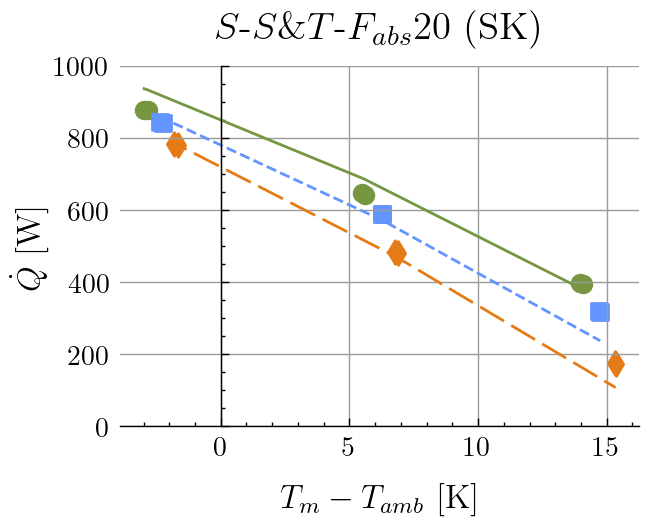

In [26]:
fig, ax = plt.subplots(figsize=(rconfig.wcol_in/2, rconfig.hfig(0.2, unit="in")))

u_range = [(0,1), (1,3), (3,4)]
k = 0

u_list = list(triplets[0]['steadyStateConditions_df']['u'].unique())

for i, (u_min, u_max) in enumerate(u_range):
    df_f = triplets[k]['df_res'].loc[(u_min <= triplets[k]['df_res']['u']) & (triplets[k]['df_res']['u'] < u_max)].copy()
    df_f.sort_values('T_m - T_amb', inplace=True)
    
    ax.plot(df_f['T_m - T_amb'], df_f['Qdot_tube_fluid'], color = colors[i], linestyle=linestyles[i], 
             label=f'Model - u = {str(u_list[i])} m/s')
    ax.scatter(df_f['T_m - T_amb'], df_f['Qdot_experimental'], color=colors[i], marker = markers[i],
               label=f'Experiment - u = {str(u_list[i])} m/s')

# Legend
# for i, (u_min, u_max) in enumerate(u_range):
#     df_f = triplets[k]['df_res'].loc[(u_min <= triplets[k]['df_res']['u']) & (triplets[k]['df_res']['u'] < u_max)].copy()
#     df_f.sort_values('T_m - T_amb', inplace=True)
    
#     ax.plot([], [], label=f'Model - u = {str(u_list[i])} m/s', color = colors[i], linestyle=linestyles[i])
#     ax.scatter([], [], label=f'Experiment - u = {str(u_list[i])} m/s', color=colors[i], marker = markers[i])

# ax.set_xticks(np.arange(0, max(df_f['T_m - T_amb']) + 10, 5))
# ax.set_yticks(np.arange(0,800+10, 200))

# Move the x-axis and y-axis to the center
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

# Remove top and right spines (the frame)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Keep ticks at the original margin positions
ax.xaxis.set_ticks_position('bottom')  # Ticks stay at the bottom
ax.yaxis.set_ticks_position('left')    # Ticks stay at the left

# ax.tick_params(axis='x', which='major', pad=35)
# ax.tick_params(axis='x', which='major', pad=120) # for k=1 or 3
ax.tick_params(axis='y', which='major', pad=40)

plt.grid(linewidth=0.5, color=rconfig.get_hex_code('grey', 70))

ax.set_xlabel(r'$T_m - T_{amb}$ [K]')
ax.set_ylabel(r'$\dot{Q}$ [W]',
              labelpad = 2 
              )

ax.set_ylim(0,1000)

# ax.legend(loc='lower center', ncol=3, frameon=False)

# Legend
# plt.axis('off')  # Turns off the axes
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=3, frameon=False)  # Adjust the legend location and style

ax.set_title(r'$S \text{-} S\&T \text{-} F_{abs} 20$ (SK)',loc = 'center', pad = 10, fontsize = 14)

# ax

plt.show()

In [27]:
fig.savefig(r'G:\Mon Drive\GitHub\VDE_thesis\image\Chapter_TH\TH-3-protos-SK-exp-num-A.png', dpi=600)

### Figure B - 

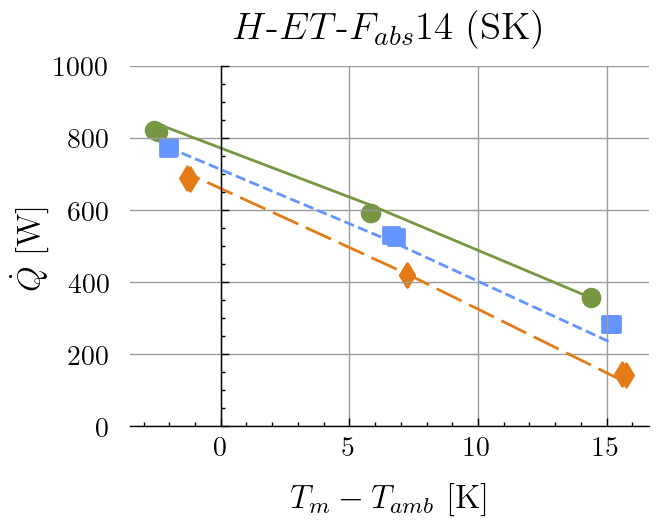

In [28]:
fig, ax = plt.subplots(figsize=(rconfig.wcol_in/2, rconfig.hfig(0.2, unit="in")))

u_range = [(0,1), (1,3), (3,4)]
k = 1

u_list = list(triplets[0]['steadyStateConditions_df']['u'].unique())

for i, (u_min, u_max) in enumerate(u_range):
    df_f = triplets[k]['df_res'].loc[(u_min <= triplets[k]['df_res']['u']) & (triplets[k]['df_res']['u'] < u_max)].copy()
    df_f.sort_values('T_m - T_amb', inplace=True)
    
    ax.plot(df_f['T_m - T_amb'], df_f['Qdot_tube_fluid'], color = colors[i], linestyle=linestyles[i], 
             label=f'Model - u = {str(u_list[i])} m/s')
    ax.scatter(df_f['T_m - T_amb'], df_f['Qdot_experimental'], color=colors[i], marker = markers[i],
               label=f'Experiment - u = {str(u_list[i])} m/s')

# Legend
# for i, (u_min, u_max) in enumerate(u_range):
#     df_f = triplets[k]['df_res'].loc[(u_min <= triplets[k]['df_res']['u']) & (triplets[k]['df_res']['u'] < u_max)].copy()
#     df_f.sort_values('T_m - T_amb', inplace=True)
    
#     ax.plot([], [], label=f'Model - u = {str(u_list[i])} m/s', color = colors[i], linestyle=linestyles[i])
#     ax.scatter([], [], label=f'Experiment - u = {str(u_list[i])} m/s', color=colors[i], marker = markers[i])

# ax.set_xticks(np.arange(0, max(df_f['T_m - T_amb']) + 10, 5))
# ax.set_yticks(np.arange(0,800+10, 200))

# Move the x-axis and y-axis to the center
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

# Remove top and right spines (the frame)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Keep ticks at the original margin positions
ax.xaxis.set_ticks_position('bottom')  # Ticks stay at the bottom
ax.yaxis.set_ticks_position('left')    # Ticks stay at the left

# ax.tick_params(axis='x', which='major', pad=35)
# ax.tick_params(axis='x', which='major', pad=120) # for k=1 or 3
ax.tick_params(axis='y', which='major', pad=40)

plt.grid(linewidth=0.5, color=rconfig.get_hex_code('grey', 70))

ax.set_xlabel(r'$T_m - T_{amb}$ [K]')
ax.set_ylabel(r'$\dot{Q}$ [W]',
              labelpad = 2 
              )

ax.set_ylim(0,1000)

# ax.legend(loc='lower center', ncol=3, frameon=False)

# Legend
# plt.axis('off')  # Turns off the axes
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=3, frameon=False)  # Adjust the legend location and style

ax.set_title(r'$H \text{-} ET \text{-} F_{abs} 14$ (SK)',loc = 'center', pad = 10, fontsize = 14)

# ax

plt.show()

In [29]:
fig.savefig(r'G:\Mon Drive\GitHub\VDE_thesis\image\Chapter_TH\TH-3-protos-SK-exp-num-B.png', dpi=600)

### Legend

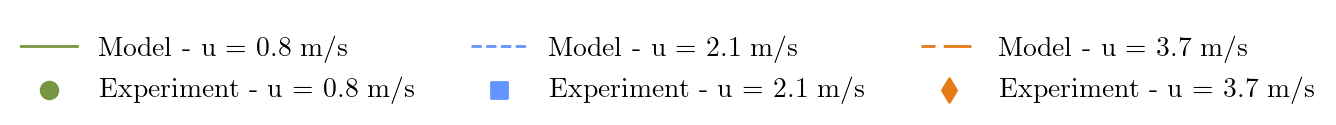

In [30]:
fig, ax = plt.subplots(figsize=(rconfig.wcol_in/2, rconfig.hfig(0.05, unit="in")))

# Legend
for i, (u_min, u_max) in enumerate(u_range):
    df_f = triplets[k]['df_res'].loc[(u_min <= triplets[k]['df_res']['u']) & (triplets[k]['df_res']['u'] < u_max)].copy()
    df_f.sort_values('T_m - T_amb', inplace=True)
    
    ax.plot([], [], label=f'Model - u = {str(u_list[i])} m/s', color = colors[i], linestyle=linestyles[i])
    ax.scatter([], [], label=f'Experiment - u = {str(u_list[i])} m/s', color=colors[i], marker = markers[i])

plt.axis('off')  # Turns off the axes

ax.legend(loc='upper center', ncol=3, frameon=False)  # Adjust the legend location and style

In [31]:
fig.savefig(r'G:\Mon Drive\GitHub\VDE_thesis\image\Chapter_TH\TH-3-protos-SK-exp-num-legendAB.png', dpi=600)

In [32]:
dic_names_exp = {'T_in' : 'T_fluid_in0',
             'T_out' : 'T_fluid_out',
             'Qdot_1_AG' : 'Qdot/AG',
             'T_amb' : 'T_amb',
             'u' : 'u'}

dic_names_num = {'T_in' : 'T_fluid_in',
             'T_out' : 'T_fluid_out',
             'Qdot_1_AG' : 'Qdot/AG',
             'T_amb' : 'T_amb',
             'u' : 'u'}

In [33]:
for _ in range(2):
    triplets[_]['steadyStateConditions_df']['Qdot/AG'] = triplets[_]['steadyStateConditions_df']['Qdot'] / triplets[_]['panelSpecs']['AG']
    triplets[_]['df_res']['Qdot/AG'] = triplets[_]['df_res']['Qdot_tube_fluid'] / triplets[_]['panelSpecs']['AG']

In [36]:
k0 = 0
tab_mat,tab_res,X = nm.find_SK(triplets[k0]['steadyStateConditions_df'],dic_names_exp,columns_list=[1,1,0,1,1,0,1,1,0],options=[],IAM=False,LSM='nnls')
triplets[k0]['steadyStateConditions_df']['Qdot/AG_reg'] = tab_mat @ X[0]
tab_mat,tab_res,X1 = nm.find_SK(triplets[k0]['df_res'],dic_names_num,columns_list=[1,1,0,1,1,0,1,1,0],options=[],IAM=False,LSM='nnls')
triplets[k0]['df_res']['Qdot/AG_reg'] = tab_mat @ X1[0]
print('exp', X[0])
print('num', X1[0])

exp [3.88360180e-01 1.71418528e+01 0.00000000e+00 1.29561916e+00
 0.00000000e+00 0.00000000e+00 1.30051211e-02 0.00000000e+00
 0.00000000e+00]
num [ 0.39197106 19.65036944  0.          1.18936163  0.          0.
  0.02282822  0.          0.        ]
